예제 7.8 감성 분석

In [ ]:
# 예제 7.8 감성 분석(한글 NSMC 데이터셋) 양방향 LSTM

# konlpy 설치
!pip install konlpy

In [ ]:
# 셋업
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.layers import TextVectorization
from konlpy.tag import Okt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 데이터셋 다운로드
url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
train_df = pd.read_csv(url, sep='\t')   # 학습 데이터

url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
test_df = pd.read_csv(url, sep='\t')    # 테스트 데이터

# 소규모 데이터셋 준비
train_df = train_df.iloc[::10].reset_index(drop=True)   # 1/10 축소
test_df = test_df.iloc[::20].reset_index(drop=True)     # 1/20 축소

print(train_df.shape)   # 학습 데이터 shape 확인
print(test_df.shape)    # 테스트 데이터 shape 확인

(15000, 3)
(2500, 3)


In [ ]:
# 상위 데이터 확인
train_df.head(10)

id                                           document  label
0  9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1  9008700                                   걍인피니트가짱이다.진짜짱이다♥      1
2  4581211          나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님      1
3  6331922  엄포스의 위력을 다시 한번 깨닫게 해준 적.남 꽃검사님도 연기 정말 좋았어요! 완전...      1
4  9336496                                   단순하면서 은은한 매력의 영화      1
5  9063648  영화가 사람의 영혼을 어루만져 줄 수도 있군요 거친 세상사를 잠시 잊고 동화같은 영...      1
6  1031725                        보는내내 그대로 들어맞는 예측 카리스마 없는 악역      0
7  2192046                                아 일본영화 다이런건가?? 유치하다      0
8  2009382              뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..      0
9  7852366                                      성룡영화중 최악인듯 ㅋㅋ      0

In [ ]:
# 레이블별(긍정/부정) 수 확인
print(f"train dataset: \n{train_df['label'].value_counts()} \n")
print(f"test dataset: \n{test_df['label'].value_counts()}")

train dataset: 
0    7500
1    7500
Name: label, dtype: int64 

test dataset: 
1    1283
0    1217
Name: label, dtype: int64


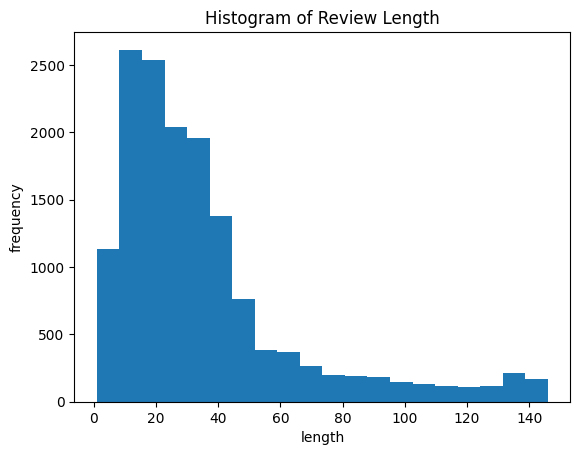

In [ ]:
# 학습 데이터 시각화(리뷰 길이 히스토그램)
length = train_df['document'].str.len()

plt.hist(length, bins=20)
plt.xlabel('length')
plt.ylabel('frequency')
plt.title('Histogram of Review Length')

plt.show()

In [ ]:
# 텍스트 정제
train_df['document'] = train_df['document'].str.replace("[^A-Za-z가-힣]", " ")

# 한글 형태소 분석
okt = Okt()   # 한글 형태소 분석기

stop_words = ['가', '을', '은', '과', '의', '도',  # 불용어 지정
              '이', '를', '는', '와', '에', '들']

def tokenize(text):   # 토큰화 함수 정의
    tokens = okt.morphs(text)
    return [token for token in tokens if token not in stop_words]

train_df['document'] = train_df['document'].apply(lambda x: ' '.join(tokenize(x)))

train_df.head(10)

<ipython-input-4-f8a6154d609d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['document'] = train_df['document'].str.replace("[^A-Za-z가-힣]", " ")


id                                           document  label
0  9976970                                  아 더빙 진짜 짜증나네요 목소리      0
1  9008700                                걍 인피니트 짱 이다 진짜 짱 이다      1
2  4581211               나름 심오한 뜻 있는 듯 그냥 학생 선생 놀아나는 영화 절대 아님      1
3  6331922  엄포스 위력 다시 한번 깨닫게 해준 적 남 꽃 검사 님 연기 정말 좋았어요 완전 명...      1
4  9336496                                    단순하면서 은은한 매력 영화      1
5  9063648  영화 사람 영혼 어루만져 줄 수도 있군요 거친 세 상사 잠시 잊고 동화 같은 영화 ...      1
6  1031725                        보는내내 그대로 들어맞는 예측 카리스마 없는 악역      0
7  2192046                               아 일본 영화 다 이런 건가 유치하다      0
8  2009382                  뭐 냐 시작 하고 분만 나왔다 리플릿 사진 보며 불안하더니만      0
9  7852366                                     성룡 영화 중 최악 인 듯      0

In [ ]:
# 워드 클라우드 라이브러리 설치
!pip install wordcloud

In [ ]:
# 한글 폰트를 사용하기 위해 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


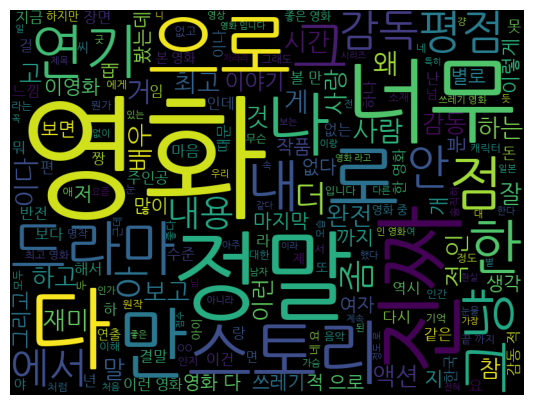

In [ ]:
# 워드 클라우드 시각화
from wordcloud import WordCloud

font_path = '/content/drive/MyDrive/Colab Notebooks/NanumFont/NanumGothic.ttf'
cloud = WordCloud(font_path=font_path, width=800, height=600)\
    .generate(" ".join(train_df['document']))

plt.figure(figsize=(10, 5))
plt.imshow(cloud)
plt.axis('off')

plt.show()

In [ ]:
# 텍스트 벡터화
vocab_size = 20000     # 어휘 사전 크기
sequence_length = 50   # 시퀀스 길이

vectorizer = TextVectorization(max_tokens=vocab_size,
                               standardize='lower_and_strip_punctuation',
                               split='whitespace',
                               output_mode='int',   # 정수 출력
                               output_sequence_length=sequence_length)

vectorizer.adapt(train_df['document'])   # 어휘 사전 생성

word_indexing = dict(zip(vectorizer.get_vocabulary(),
                         range(len(vectorizer.get_vocabulary()))))
print(f"word_indexing: {word_indexing}")   # 단어 인덱싱 확인

train_ds = vectorizer(train_df['document'])
print(train_ds[5])   # 텍스트 벡터화 확인

original_text = ' '.join(
    vectorizer.get_vocabulary()[i] for i in train_ds[5].numpy())
print(original_text)   # 원래의 텍스트 확인

word_indexing: {'': 0, '[UNK]': 1, '영화': 2, '너무': 3, '한': 4, '다': 5, '정말': 6, '만': 7, '적': 8, '으로': 9, '진짜': 10, '로': 11, '점': 12, '에서': 13, '것': 14, '연기': 15, '내': 16, '평점': 17, '나': 18, '최고': 19, '잘': 20, '인': 21, '이런': 22, '그': 23, '안': 24, '스토리': 25, '생각': 26, '이다': 27, '드라마': 28, '사람': 29, '못': 30, '왜': 31, '게': 32, '감동': 33, '고': 34, '아': 35, '보고': 36, '하는': 37, '더': 38, '배우': 39, '거': 40, '감독': 41, '시간': 42, '말': 43, '하고': 44, '본': 45, '요': 46, '때': 47, '그냥': 48, '재미': 49, '내용': 50, '뭐': 51, '좀': 52, '까지': 53, '쓰레기': 54, '중': 55, '지': 56, '없는': 57, '네': 58, '보다': 59, '수': 60, '볼': 61, '봤는데': 62, '할': 63, '정도': 64, '사랑': 65, '다시': 66, '좋은': 67, '마지막': 68, '작품': 69, '없다': 70, '저': 71, '같은': 72, '액션': 73, '처음': 74, '있는': 75, '완전': 76, '입니다': 77, '돈': 78, '하나': 79, '이건': 80, '주인공': 81, '라': 82, '참': 83, '장면': 84, '없고': 85, '걸': 86, '개': 87, '보는': 88, '별로': 89, '이렇게': 90, '이야기': 91, '하': 92, '연출': 93, '봐도': 94, '임': 95, '부터': 96, '지금': 97, '느낌': 98, '최악': 99, '면': 100, '그리고': 101, '듯

In [ ]:
# 학습/검증 데이터 분할
train_size = int(0.8 * len(train_ds))

x_train = train_ds[:train_size]
x_valid = train_ds[train_size:]
y_train = train_df['label'][:train_size]
y_valid = train_df['label'][train_size:]

print(x_train.shape, y_train.shape)   # 학습 데이터 shape 확인
print(x_valid.shape, y_valid.shape)   # 검증 데이터 shape 확인

(12000, 50) (12000,)
(3000, 50) (3000,)


In [ ]:
# 모델 생성
model = Sequential([
    Embedding(vocab_size, 128),                       # 임베딩 벡터 128차원
    Bidirectional(LSTM(16, return_sequences=True)),   # 뉴런 16개
    Bidirectional(LSTM(16)),                          # 뉴런 16개
    Dense(1, activation='sigmoid')                    # 출력층 뉴런 1개
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(x_train, y_train, batch_size=32, epochs=5,
                    verbose=0,
                    validation_data=(x_valid, y_valid))

Epoch 1/5
375/375 [==============================] - 64s 116ms/step - loss: 0.5199 - accuracy: 0.7266 - val_loss: 0.4174 - val_accuracy: 0.8097
Epoch 2/5
375/375 [==============================] - 14s 38ms/step - loss: 0.2614 - accuracy: 0.8989 - val_loss: 0.4355 - val_accuracy: 0.8073
Epoch 3/5
375/375 [==============================] - 14s 37ms/step - loss: 0.1362 - accuracy: 0.9523 - val_loss: 0.5394 - val_accuracy: 0.7950
Epoch 4/5
375/375 [==============================] - 15s 39ms/step - loss: 0.0833 - accuracy: 0.9728 - val_loss: 0.6079 - val_accuracy: 0.7890
Epoch 5/5
375/375 [==============================] - 12s 33ms/step - loss: 0.0590 - accuracy: 0.9807 - val_loss: 0.7650 - val_accuracy: 0.7820


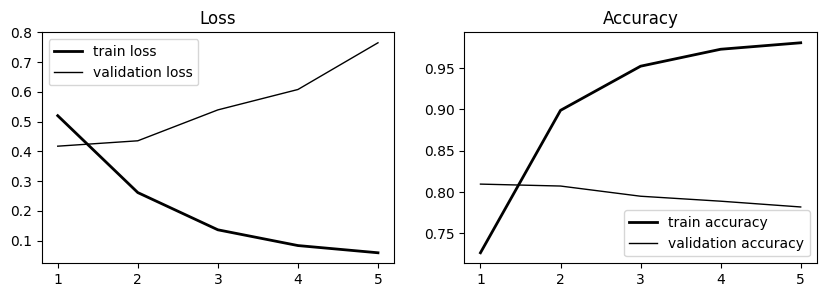

In [ ]:
# 학습 결과 시각화
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axs[0].plot(range(1, len(history.history['loss']) + 1),
            history.history['loss'], label='train loss',
            color='black', linewidth=2)
axs[0].plot(range(1, len(history.history['val_loss']) + 1),
            history.history['val_loss'], label='validation loss',
            color='black', linewidth=1)
axs[0].set_title('Loss')
axs[0].legend(loc='best')

axs[1].plot(range(1, len(history.history['accuracy']) + 1),
            history.history['accuracy'], label='train accuracy',
            color='black', linewidth=2)
axs[1].plot(range(1, len(history.history['val_accuracy']) + 1),
            history.history['val_accuracy'], label='validation accuracy',
            color='black', linewidth=1)
axs[1].set_title('Accuracy')
axs[1].legend(loc='best')

plt.show()

In [ ]:
# 모델 평가
test_ds = test_df['document'].str.replace("[^A-Za-z가-힣]", " ")   # 텍스트 정제
test_ds = test_ds.apply(lambda x: ' '.join(tokenize(x)))           # 토큰화
test_ds = vectorizer(test_ds)                                      # 텍스트 벡터화

model.evaluate(test_ds, test_df['label'])

<ipython-input-12-a4527aa94ad7>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_ds = test_df['document'].str.replace("[^A-Za-z가-힣]", " ")   # 텍스트 정제


79/79 [==============================] - 1s 6ms/step - loss: 0.7849 - accuracy: 0.7716


[0.7849045395851135, 0.7716000080108643]

In [ ]:
# 모델 예측
prediction = model.predict(test_ds)
predict = (prediction >= 0.5).astype(int)   # 임계치 0.5

for i in range(5):
    print(f"document: {test_df['document'][i]}")
    print(f"label: {test_df['label'][i]}")
    print(f"predict: {int(predict[i])} \n")

79/79 [==============================] - 0s 5ms/step
document: 굳 ㅋ
label: 1
predict: 1 

document: '13일의 금요일', '나이트메어'시리즈와 함께 가장 많은 시리즈를 양산해냈던 헬레이저 시리즈의 첫편. 작가의 상상력이 돋보이는 작품이며, 갈고리로 사지찢는 고어씬은 지금보더라도 상당히 잔인하고 충격적이다.
label: 1
predict: 0 

document: EBS 한국영화특선 해서 봤다.Biff 개막작 선정되서 왤까 궁금 했었는데 봐도 이율 모르겠다...
label: 0
predict: 0 

document: 콩콩~~~~ㅋㄲㅈㅁ
label: 0
predict: 0 

document: 솔직히 이건 C급 그 이하의 영화이긴 함 ㅎㅎ;
label: 0
predict: 0 



In [ ]:
# 모델 예측(실제 텍스트 입력)
import re

sentence = "미션 임파서블 7은 역시 기대에 어긋나지 않는다."

text = re.sub("[^A-Za-z가-힣]", " ", sentence)   # 텍스트 정제
text = ' '.join(tokenize(text))                  # 토큰화
text = vectorizer(text)                          # 텍스트 벡터화

text = np.expand_dims(text, axis=0)   # 배치 차원 추가

prediction = model.predict(text)
predict = (prediction >= 0.5).astype(int)   # 임계치 0.5

print(f"sentence: {sentence}")
print(f"predict: {int(predict)}")

1/1 [==============================] - 0s 20ms/step
sentence: 미션 임파서블 7은 역시 기대에 어긋나지 않는다.
predict: 1
